In [2]:
if run_loc == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')

In [3]:
import tensorflow as tf
import numpy as np
import time
import collections
import pandas
from tqdm.notebook import tqdm
import json
import random
import matplotlib.pyplot as plt
import re
import os
#from PIL import Image

In [4]:
tf.debugging.set_log_device_placement(True)
gpus = tf.config.list_logical_devices('GPU')
cpus = tf.config.list_logical_devices('CPU')
gpus, cpus

([LogicalDevice(name='/device:GPU:0', device_type='GPU')],
 [LogicalDevice(name='/device:CPU:0', device_type='CPU')])

In [7]:
testing = False

run_loc = 'localhost' # options are localhost, colab, and gce

run_loc_params = {'top_k': {'localhost': 16000, 'localhost_gpu': 16000, 'colab': 16000, 'gce': 16000},
                 'batch_size': {'localhost': 64, 'localhost_gpu': 3, 'colab': 4, 'gce': 4},
                 'num_encoders': {'localhost': 12, 'localhost_gpu': 2, 'colab': 12, 'gce': 12},
                 'num_decoders': {'localhost': 4, 'localhost_gpu': 2, 'colab': 4, 'gce': 4},
                 'd_model': {'localhost': 768, 'localhost_gpu': 256, 'colab': 768, 'gce': 768},
                 'num_heads': {'localhost': 12, 'localhost_gpu': 8, 'colab': 8, 'gce': 8},
                 'dff': {'localhost': 2048, 'localhost_gpu': 1024, 'colab': 2048, 'gce': 2048},
                 'json': {'localhost': './reddit_roasts.json',
                          'localhost_gpu': './reddit_roasts.json',
                          'colab': './drive/MyDrive/reddit_roasts.json',
                          'gce': './reddit_roasts.json'},
                 'img_dir': {'localhost': './faces/faces/',
                             'localhost_gpu': './faces/faces/',
                             'colab': './drive/MyDrive/faces/',
                             'gce': './faces/faces/'},
                 'device_type': {'localhost': 'CPU', 'localhost_gpu': 'GPU', 'colab': 'GPU', 'gce': 'GPU'}}
run_params = {key: run_loc_params[key][run_loc] for key in run_loc_params.keys()}

devices = tf.config.list_logical_devices(run_params['device_type'])    
if len(devices) > 1:
    strategy = tf.distribute.MirroredStrategy(devices)
else:
    strategy = tf.distribute.OneDeviceStrategy(devices[0])
print('Run Location: {}'.format(run_loc), '\n'.join(['{}: {}'.format(key, item) for (key, item) in run_params.items()]), sep='\n')
print('Distribution Strategy:', strategy)

Run Location: localhost
top_k: 16000
batch_size: 64
num_encoders: 12
num_decoders: 4
d_model: 768
num_heads: 12
dff: 2048
json: ./reddit_roasts.json
img_dir: ./faces/faces/
device_type: CPU
Distribution Strategy: <tensorflow.python.distribute.one_device_strategy.OneDeviceStrategy object at 0x00000227BA5D2B08>


In [4]:
top_k = run_params['top_k']
top_k

16000

In [5]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(1000, (2*(i//2)) / np.float32(d_model))
    return pos * angle_rates

In [6]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

In [7]:
if testing:
    pos_encoding = positional_encoding(64, d_model=256)
    plt.figure(figsize=(24,20))
    plt.imshow(pos_encoding[0])
    plt.xlabel('Depth in Encoding Vector')
    plt.ylabel('Position in Sequence')
    plt.show()

In [8]:
BATCH_SIZE = run_params['batch_size']
num_patches = 576
patch_size = 16

In [9]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead)
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

In [10]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

In [11]:
if testing:
    temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
    y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
    out, attn = temp_mha(y, k=y, q=y, mask=None)
    print(out.shape, attn.shape)

In [12]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, num_heads, d_model=256, dff=2048, dropout=.1, name=None):
        super().__init__(name=name)
        self.self_attention = tf.keras.layers.MultiHeadAttention(num_heads, key_dim=d_model)
        self.fc1 = tf.keras.layers.Dense(dff, activation=tf.keras.activations.gelu)
        self.fc2 = tf.keras.layers.Dense(d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)
        self.layer_norm1 = tf.keras.layers.LayerNormalization()
        self.layer_norm2 = tf.keras.layers.LayerNormalization()

    def call(self, x, training, mask):
        attention_weights, _ = self.self_attention(x, x, attention_mask=mask,
                                                    return_attention_scores=True)
        normalized = self.layer_norm1(x + attention_weights)
        x = self.fc2(self.dropout(self.fc1(normalized), training=training))
        return self.layer_norm2(x + normalized)

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.fc1 = tf.keras.layers.Dense(dff, activation=tf.keras.activations.gelu)
        self.fc2 = tf.keras.layers.Dense(d_model)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)
        seq_len = x.shape[1]
        attn1, attn_weights_block1 = self.mha1(x, x, x, mask=look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
        
        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, mask=padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.fc2(self.dropout3(self.fc1(out2), training=training))
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [13]:
class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="SAME",
        )
        
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = tf.keras.layers.Dense(units=projection_dim)
        self.position_embedding = tf.keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.expand_dims(tf.range(start=0, limit=self.num_patches, delta=1), 0)
        projection = self.projection(patch)
        embeddings = self.position_embedding(positions)
        encoded = projection + embeddings
        return encoded

In [14]:
if testing:
    img_array = tf.random.uniform([64,384,384,3], minval=0, maxval=1)
    print(img_array.shape)
    patches = Patches(patch_size)(img_array)
    encoded = PatchEncoder(num_patches, 256)(patches)
    encoded.shape

In [15]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff,
               maximum_positional_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers
        self.patches = Patches(16)
        self.patch_encoder = PatchEncoder(num_patches, d_model)
        self.pos_encoding = positional_encoding(maximum_positional_encoding,
                                                self.d_model)
        self.enc_layers = [EncoderLayer(num_heads, d_model, dff, dropout=rate)
                          for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        self.flatten = tf.keras.layers.Flatten()

    def call(self, x, training, mask):
        patches = self.patches(x)
        x = self.patch_encoder(patches)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        return x

In [16]:
if testing:
    sample_encoder = Encoder(num_layers=2, d_model=768, num_heads=12,
                          dff=2048, maximum_positional_encoding=32)
    temp_input = tf.random.uniform((BATCH_SIZE,384,384,3), dtype=tf.float32, minval=0, maxval=1.)
    sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)
    print(sample_encoder_output.shape)

In [17]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq,0),tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :] # (batch_size, 1, 1, seq_len)
    #return seq[:, :, tf.newaxis]
create_padding_mask([[5, 4, 3, 2, 1, 0, 0, 0, 0, 0]])

<tf.Tensor: shape=(1, 1, 1, 10), dtype=float32, numpy=array([[[[0., 0., 0., 0., 0., 1., 1., 1., 1., 1.]]]], dtype=float32)>

In [18]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size,size)), -1, 0)
    return mask # (seq_len, seq_len)
create_look_ahead_mask(4)

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0., 1., 1., 1.],
       [0., 0., 1., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.]], dtype=float32)>

In [19]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        #print('Seq length:', seq_len)
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        #print('Sequence shape:', x.shape)
        #print('Encoder output shape:', enc_output.shape)
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        #print('Before decoder layers shape:', x.shape)
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)
            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [20]:
if testing:
    sample_decoder = Decoder(num_layers=2, d_model=256, num_heads=8,
                          dff=1024, target_vocab_size=8000,
                          maximum_position_encoding=5000)
    temp_input = tf.random.uniform((BATCH_SIZE, 74), dtype=tf.int64, minval=0, maxval=200)
    padding_mask = tf.random.uniform((BATCH_SIZE, 74, 576), dtype=tf.int32, minval=0, maxval=1)
    look_ahead_mask = create_look_ahead_mask(74)
    output, attn = sample_decoder(temp_input,
                                enc_output=sample_encoder_output,
                                training=False,
                                look_ahead_mask=look_ahead_mask,
                                padding_mask=None)

    print(output.shape, attn['decoder_layer1_block2'].shape)

In [21]:
if testing:
    with tf.device('/cpu:0'):
        mha = tf.keras.layers.MultiHeadAttention(8, 256)
        enc_output = tf.random.uniform([64,576,256])
        dec_latent = tf.random.uniform([64,74,256])
        mask = tf.random.uniform([64,74,576], dtype=tf.float32, maxval=1)
        print(mha(dec_latent, enc_output, enc_output, mask).shape)

In [22]:
def augmentation_model():
    model = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomRotation(factor=(-.125,.125)),
        tf.keras.layers.experimental.preprocessing.RandomFlip(),
        tf.keras.layers.experimental.preprocessing.RandomContrast(factor=(.5,1.5))
    ])
    return model

In [23]:
class Transformer(tf.keras.Model):
    def __init__(self, num_encoders, num_decoders, d_model, num_heads, dff,
               maximum_positional_encoding, target_vocab_size, target, rate=0.1):
        super(Transformer, self).__init__()
        self.augmenter = augmentation_model()
        self.tokenizer = Encoder(num_encoders, d_model, num_heads, dff,
                                maximum_positional_encoding, rate)
        self.decoder = Decoder(num_decoders, d_model, num_heads, dff,
                               target_vocab_size, target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
  
    def call(self, x):
        inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask = x
        enc_output = self.tokenizer(self.augmenter(inp), training, enc_padding_mask)

        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask
        )

        final_output = self.final_layer(dec_output)

        return final_output, attention_weights
    
    def train_step(self, data, *args, **kwargs):
        inp, target = data
        tar_inp = target[:, :-1]
        tar_real = target[:, 1:]
        combined_mask, dec_padding_mask = create_masks(tar_inp)
        with tf.GradientTape() as tape:
            y_pred, _ = self((inp, tar_inp,
                                     True,
                                     None,
                                     combined_mask,
                                     None), training=True)
            loss = self.compiled_loss(tar_real, y_pred, regularization_losses=self.losses)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(tar_real, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        inp, target = data
        tar_inp = target[:, :-1]
        tar_real = target[:, 1:]
        combined_mask, dec_padding_mask = create_masks(tar_inp)
        y_pred, _ = self((inp, tar_inp,
                             True,
                             None,
                             combined_mask,
                             None), training=False)
        loss = self.compiled_loss(tar_real, y_pred, regularization_losses=self.losses)
        # Update the metrics.
        self.compiled_metrics.update_state(tar_real, y_pred)
        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}

In [24]:
def create_masks(tar):
    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return combined_mask, dec_target_padding_mask

In [25]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [26]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.cast(tf.argmax(pred, axis=-1), dtype=real.dtype))

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [27]:
if testing:
    sample_transformer = Transformer(
      num_encoders=1, num_decoders=1, d_model = 256, num_heads = 8, dff = 2048,
      target_vocab_size = 8000, target=6000, maximum_positional_encoding=512)
    sample_transformer.compile(loss=loss_function, metrics=[accuracy_function])
    x = tf.random.uniform((16, 384, 384, 3))
    y = tf.random.uniform((16, 32), minval=0, maxval=4000)
    with tf.device('/cpu:0'):
        sample_transformer.evaluate(x, y)

In [28]:
real_example = tf.convert_to_tensor([[79,80,50, 0, 0, 0]])
logits = tf.one_hot([79,80,50, 3, 3, 3], 8000) * 1
pred_example = tf.expand_dims(logits, 0)
accuracy_function(real_example, pred_example), loss_function(real_example, pred_example)

(<tf.Tensor: shape=(), dtype=float32, numpy=1.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=7.987412>)

In [29]:
logits = tf.one_hot([3,3,3, 3, 3, 3], 8000) * 1
print(logits[0][:5])
pred_example = tf.expand_dims(logits, 0)
accuracy_function(real_example, pred_example), loss_function(real_example, pred_example)

tf.Tensor([0. 0. 0. 1. 0.], shape=(5,), dtype=float32)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=8.9874115>)

In [30]:
d_model = run_params['d_model']
dff = run_params['dff']
num_heads = run_params['num_heads']
num_encoders = run_params['num_encoders']
num_decoders = run_params['num_decoders']
print('d_model: ', d_model, 'dff: ', dff, 'num_heads: ', num_heads)

d_model:  768 dff:  2048 num_heads:  12


In [31]:
transformer = Transformer(num_encoders=num_encoders, num_decoders=num_decoders, d_model=d_model, 
                          num_heads = num_heads, dff = dff,
                          target_vocab_size = top_k, target=top_k,
                          maximum_positional_encoding=32, rate=.3)

In [32]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000, baseline_lr = 1e-4):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
        self.baseline_lr = baseline_lr

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        val = tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
        return (tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2) * self.baseline_lr) / self.baseline_lr

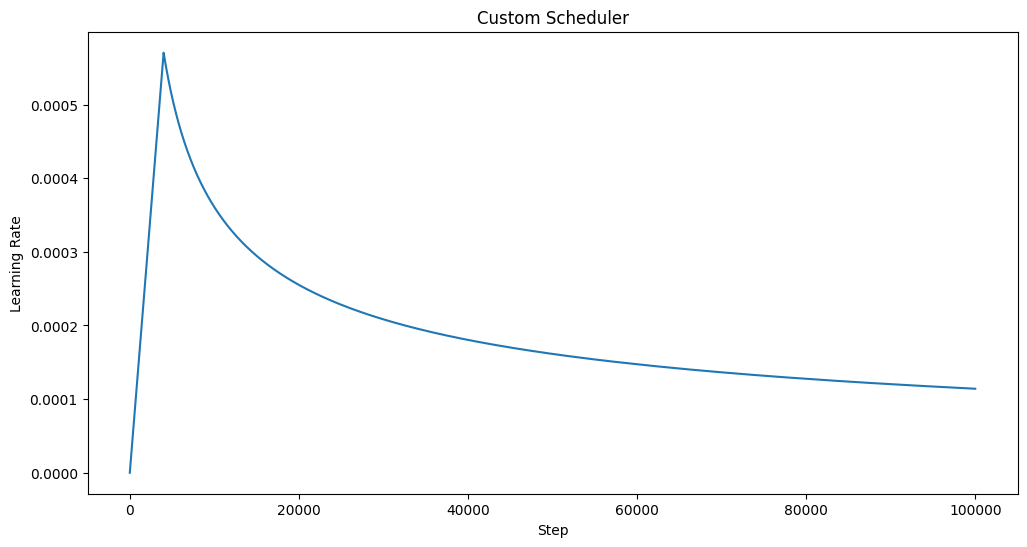

In [33]:
learning_rate = CustomSchedule(d_model, baseline_lr=1e-4)
fig = plt.figure(figsize=(12,6))
plt.plot(learning_rate(tf.range(0, limit=1e5)))
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.title('Custom Scheduler')
plt.show()

In [34]:
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

callbacks = [tf.keras.callbacks.ModelCheckpoint('checkpoints/', save_best_only=True, save_weights_only=True, verbose=1),
            tf.keras.callbacks.EarlyStopping(patience=1, restore_best_weights=True, verbose=1)]

In [35]:
transformer.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy_function])

In [36]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(tf.image.resize(img, (384, 384)), tf.float32) / 255.
    return img, image_path

In [37]:
def get_data(path, annotations_json, is_roast=False, split=[.8,.1,.1], subset=None, tokenizer=None, 
             batch_size=16, return_text=False):
    with open(annotations_json, 'r') as f:
        annotations = json.load(f)
    
    image_path_to_caption = collections.defaultdict(list)
    if is_roast:
        for entry in annotations['info']:
            for roast in entry['Roasts']:
                if roast != 'removed':
                    temp_caption = re.sub('([.,\'"!?()0-9])', r' \1 ', roast)
                    caption = f"<start> {temp_caption} <end>"
                    image_path = path + '{}.jpg'.format(entry['ID'])
                    image_path_to_caption[image_path].append(caption)
    else:
        for val in annotations['annotations']:
            temp_caption = re.sub('([.,\'"!?()0-9])', r' \1 ', val['caption'])
            caption = f"<start> {temp_caption} <end>"
            image_path = path + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
            image_path_to_caption[image_path].append(caption)
    
    image_paths = list(image_path_to_caption.keys())
    random.shuffle(image_paths)
    
    usable_image_paths = image_paths if not subset else image_paths[:subset]
    
    num = len(usable_image_paths)
    train_image_paths = usable_image_paths[:int(num*split[0])]
    test_image_paths = usable_image_paths[int(num*split[0]):int(num*split[0]+num*split[1])]
    val_image_paths = usable_image_paths[int(num*split[0]+num*split[1]):]
    
    if not tokenizer:
        tokenizer = create_tokenizer_from_texts(top_k, [image_path_to_caption[path] for path in train_image_paths])
    
    train_dataset = get_dataset(train_image_paths, image_path_to_caption, batch_size, tokenizer)
    test_dataset = get_dataset(test_image_paths, image_path_to_caption, batch_size, tokenizer)
    val_dataset = get_dataset(val_image_paths, image_path_to_caption, batch_size, tokenizer)
    if return_text:
        return (train_dataset, test_dataset, val_dataset), tokenizer, [image_path_to_caption[path] for path in train_image_paths]
    return (train_dataset, test_dataset, val_dataset), tokenizer

def get_dataset(image_paths, image_path_to_caption, batch_size, tokenizer):
    captions = []
    img_name_vector = []
    
    for image_path in image_paths:
        caption_list = image_path_to_caption[image_path]
        captions.extend(caption_list)
        img_name_vector.extend([image_path] * len(caption_list))
        
    sequences = tokenizer.texts_to_sequences(captions)
    cap_vector = tf.keras.preprocessing.sequence.pad_sequences(sequences, padding='post', maxlen=32)
    #cap_vector = sequences
    img_to_cap_vector = collections.defaultdict(list)
    for img, cap in zip(img_name_vector, cap_vector):
        img_to_cap_vector[img].append(cap)
    
    BUFFER_SIZE = 1000
    dataset = tf.data.Dataset.from_tensor_slices((img_name_vector, cap_vector))
    dataset = dataset.map(lambda x, y: (load_image(x)[0], y))
    # Shuffle and batch
    dataset = dataset.shuffle(BUFFER_SIZE, seed=40).batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

def create_tokenizer_from_texts(top_k, texts):
    total_texts = []
    for text in texts:
        for t in text:
            total_texts.append(t)
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                     oov_token='<unk>',
                                                     filters='#$%&*+.,-/;=@[\]^_`{|}~')
    tokenizer.fit_on_texts(total_texts)
    tokenizer.word_index['<pad>'] = 0
    tokenizer.index_word[0] = '<pad>'
    #tokenizer.word_index['<end>'] = top_k-1
    #tokenizer.index_word[top_k-1] = '<end>'
    return tokenizer

def create_tokenizer_from_file(top_k, filename):
    total_texts = []
    with open(filename, 'r', encoding='utf-8') as f:
        for line in f:
            total_texts.append(line)
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                     oov_token='<unk>',
                                                     filters='#$%&*+.,-/;=@[\]^_`{|}~\t\n')
    tokenizer.fit_on_texts(total_texts)
    tokenizer.word_index['<pad>'] = 0
    tokenizer.index_word[0] = '<pad>'
    #tokenizer.word_index['<end>'] = top_k-1
    #tokenizer.index_word[top_k-1] = '<end>'
    return tokenizer

def save_all_train_annotations(filename, texts):
    with open(filename, 'w', encoding='utf-8') as f:
        for text in texts:
            f.writelines([t+'\n' for t in text])

In [38]:
re.sub('([.,\'"!?()0-9])', r' \1 ', 'Testing! All aboard? We (not they) are "testing" [now]. Let\'s go, buddy. 123456 I\'m not happy')

'Testing !  All aboard ?  We  ( not they )  are  " testing "  [now] .  Let \' s go ,  buddy .   1  2  3  4  5  6  I \' m not happy'

In [39]:
roast_annotation_file = run_params['json']
REDDIT_PATH = run_params['img_dir']

print('Roasts file: ', roast_annotation_file)
print('Image directory: ', REDDIT_PATH)

Roasts file:  ./reddit_roasts.json
Image directory:  ./faces/faces/


In [40]:
import pickle

if run_loc == 'colab':
    with open('./drive/MyDrive/master_tokenizer.pickle', 'rb') as f:
        roast_tokenizer = pickle.load(f)
else:
    with open('master_tokenizer.pickle', 'rb') as f:
        roast_tokenizer = pickle.load(f)

In [41]:
def show_example(dataset, tokenizer):
    for (imgs, captions) in dataset.take(1):
        img = imgs[0]
        plt.imshow(imgs[0])
        plt.show()
        print('Sequence:', captions[0])
        print('Caption:', [tokenizer.index_word[i] for i in captions[0].numpy() if i != 0])
    return img

In [42]:
(roast_train_dataset, roast_test_dataset, roast_val_dataset), roast_tokenizer = get_data(REDDIT_PATH, roast_annotation_file, is_roast=True,
                                                                     subset=None, batch_size=BATCH_SIZE,
                                                                           tokenizer=roast_tokenizer)

In [43]:
roast_train_dataset.element_spec

(TensorSpec(shape=(64, 384, 384, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(64, 32), dtype=tf.int32, name=None))

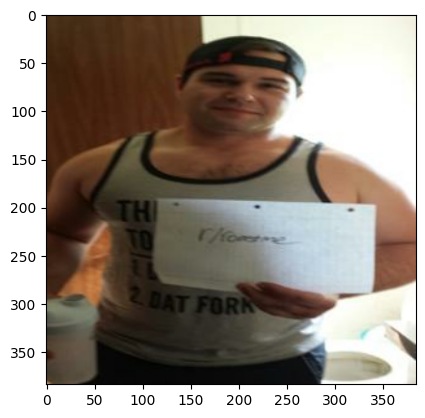

Sequence: tf.Tensor(
[   2  294   31    4 3226    6  619    9    7 3187    7   21    1   21
  436    8   24   26 1540   46   50   11 1600    3    0    0    0    0
    0    0    0    0], shape=(32,), dtype=int32)
Caption: ['<start>', 'maybe', 'if', 'you', 'tied', 'a', 'weight', 'to', 'your', 'fork', 'your', '"', '<unk>', '"', 'wouldn', "'", 't', 'have', 'gotten', 'so', 'out', 'of', 'control', '<end>']


In [44]:
show_example(roast_train_dataset, roast_tokenizer);

In [45]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [46]:
gpu_info = !nvidia-smi
print('\n'.join(gpu_info))

Thu Sep  2 12:57:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 471.41       Driver Version: 471.41       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A    0C    P0    N/A /  N/A |   1521MiB /  2048MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
with tf.device(run_params['device']):
    transformer.fit(roast_train_dataset, validation_data=roast_test_dataset, epochs=9, callbacks=callbacks)

Epoch 1/9
   5/2512 [..............................] - ETA: 520:15:55 - loss: 9.7312 - accuracy_function: 2.3838e-04

In [ ]:
transformer.summary()

In [ ]:
transformer.evaluate(roast_val_dataset)

In [ ]:
def greedy_decoder(predictions):
  #print(tf.argmax(predictions, axis=-1), tf.argmin(predictions, axis=-1))
  return tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

def greedy_non_unk_decoder(predictions):
    vals, indices = tf.math.top_k(predictions, k=2)
    return tf.cast(tf.reduce_sum(vals * tf.cast(tf.math.logical_not(tf.math.equal(indices, 4)), dtype=tf.float32)), tf.int32)

def beam_search_decoder(predictions, beam_width, top_paths):
    sequence_lengths = tf.cast(tf.fill([predictions.shape[0]], predictions.shape[1]), tf.int32)
    predictions = tf.transpose(predictions, perm=[1,0,2])
    print(sequence_lengths)
    print(predictions.shape)

    decoded, log_probabilities = tf.compat.v1.nn.ctc_beam_search_decoder(
                  predictions, sequence_lengths, beam_width=beam_width, top_paths=top_paths, merge_repeated=False
            )
    print('Decoded:', tf.sparse.to_dense(decoded[0]))
    print('Log probabilities:', log_probabilities)
    return tf.sparse.to_dense(decoded[0])

def probabilistic_decoder(predictions, temperature):
    predicted_id = tf.random.categorical(predictions[0]/temperature, num_samples=1)[0]
    return tf.expand_dims(tf.cast(predicted_id, tf.int32),0)

In [ ]:
def generate_roast(image, tokenizer, start_text=None, max_length=75, temperature=1.):
    encoder_input = tf.expand_dims(image,0)
    start, end = tokenizer.word_index['<start>'], tokenizer.word_index['<end>']
    if start_text:
        output = [start] + tokenizer.texts_to_sequences([start_text])[0]
    else:
        output = [start]
    output = tf.convert_to_tensor(output)
    output = tf.expand_dims(output, 0)
    for i in range(max_length-len(output)):
        lookahead_mask, dec_padding_mask = create_masks(output)
        # predictions.shape = (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer((encoder_input,
                                                    output,
                                                    False,
                                                    None,
                                                    lookahead_mask,
                                                    None))
        #print(predictions.shape)
        predictions = predictions[:, -1:, :]
        #print(tf.argmax(predictions, axis=-1))
        predicted_id = greedy_decoder(predictions)
        #predicted_id = probabilistic_decoder(predictions, temperature=temperature)
        output = tf.concat([output, predicted_id], axis=-1)
        if predicted_id == end:
            print('Found end')
            break
    print(output.shape)
    text = tokenizer.sequences_to_texts(output.numpy())[0]
    return text, attention_weights

def plot_predictions(image, tokenizer, start_text=None, max_length=75, temperature=1., subset=25):
    encoder_input = tf.expand_dims(image,0)
    start, end = tokenizer.word_index['<start>'], tokenizer.word_index['<end>']
    if start_text:
        output = [start] + tokenizer.texts_to_sequences([start_text])[0]
    else:
        output = [start]
    output = tf.convert_to_tensor(tf.expand_dims(output,0))
    
    lookahead_mask, dec_padding_mask = create_masks(output)
    
    print('Encoder input:', encoder_input)
    print('Decoder input:', output)
    print('Lookahead mask:', lookahead_mask)
    # predictions.shape = (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer((encoder_input,
                                                output,
                                                False,
                                                None,
                                                lookahead_mask,
                                                None))
    print('Predictions:', tf.argmax(predictions, axis=-1))
    predictions = predictions[:, -1:, :subset]
    print(predictions)
    x_ticks = np.arange(8000)[:subset]

    fig = plt.figure(figsize=(10,8))
    ax = plt.gca()
    ax.bar(x_ticks, predictions[0][0])
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([tokenizer.index_word[i] for i in x_ticks], rotation=90)
    plt.show()
    predicted_id = greedy_decoder(predictions)
    print('Argmax:', predicted_id)
    print('Prediction:', tokenizer.index_word[predicted_id.numpy()[0][0]])
    
def print_input_pred(image, tokenizer, start_text=None):
    encoder_input = tf.expand_dims(image,0)
    start, end = tokenizer.word_index['<start>'], tokenizer.word_index['<end>']
    if start_text:
        output = [start] + tokenizer.texts_to_sequences([start_text])[0]
    else:
        output = [start]
    output = tf.convert_to_tensor(tf.expand_dims(output,0))
    
    lookahead_mask, dec_padding_mask = create_masks(output)
    
    predictions, attention_weights = transformer((encoder_input,
                                                output,
                                                False,
                                                None,
                                                lookahead_mask,
                                                None))
    print(lookahead_mask)
    print(output.shape, predictions.shape)
    print('Input:',' '.join([tokenizer.index_word[i] for i in output[0].numpy()]))
    print('Predictions:',' '.join([tokenizer.index_word[i] for i in tf.argmax(predictions, axis=-1)[0].numpy()]))

In [ ]:
img = show_example(roast_val_dataset, roast_tokenizer)

In [ ]:
image_size = 384
patch_size = 16
plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.axis("off")
plt.show()

resized_image = tf.image.resize(
    tf.convert_to_tensor([img]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy())
    plt.axis("off")
plt.show()

In [ ]:
roast_tokenizer.index_word[3]

In [ ]:
def eval_model(print_freq=200):
    start = time.time()
    test_loss.reset_states()
    test_accuracy.reset_states()
    
    for (batch, (inp, tar)) in tqdm(enumerate(roast_test_dataset)):
        test_step(inp, tar)
        
        if batch % print_freq == 0:
            print(f'Test step: Epoch {current_epoch + 1} Batch {batch} Loss {test_loss.result():.4f} Accuracy {test_accuracy.result():.4f}')
    print('Eval loss:', test_loss)
    print('Eval accuracy:', test_accuracy)
#eval_model()

In [ ]:
with tf.device('/cpu:0'):
    plot_predictions(img, roast_tokenizer, start_text='Only', subset=30)

In [ ]:
with tf.device('/cpu:0'):
    text, attention_weights = generate_roast(img, roast_tokenizer, temperature=1., start_text=None)
text

In [ ]:
with tf.device('/cpu:0'):
    print_input_pred(img, roast_tokenizer, start_text="this is a test to see if the neural network repeats itself, I believe that it will but we shall see")

In [ ]:
roast_tokenizer.index_word[1]